In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pandas as pd
#pip install plotly==5.3.1
from ipynb.fs.full.ploty_zoom import zoom


In [8]:
def getManualCount(name):
    img = cv2.imread(name,1)
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    cells, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (17,200,200), (76,255,255))
    internal, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (0,0,0), (1,1,255))
    mask = cv2.erode(mask,np.ones((15,15),np.uint8))
    external, _, cc, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    for c in cc:
        cv2.circle(img, (int(c[0]), int(c[1])), 25, (255,255,255), -1)
    
    return {"method":"Manual",
            "cells":cells-1,
            "internal":internal-1,
            "external":external-1,
            "time":0}


def getOriginalCount(name):
    name1 = name.replace("samples/","samples/result/") + "_resultText.txt"
    f = open(name1,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    data = lines[1].split()
    cells = int(data[1])
    #no txt do proj original esta saindo a contagem errada
    #infectados sao os que estao externos as celulas
    external = int(data[2])
    
    name2 = name.replace("samples/","samples/result/") + "_infoTextHSV.txt"
    f = open(name2,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.strip().split("\n")
    lines.pop(0)
    internal = len(lines)-external
    
    
    return {"method":"Original",
            "cells":cells,
            "internal":internal,
            "external":external,
            "time":float(data[3])}

def getProjectCount(name):
    name = name.replace("samples/","samples/myresults/") + "_result.txt"
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        data = lines[i].split("\t")
        if len(data) > 1:
            ret.append({
                'method'  : data[0].strip(),
                'cells'   : int(data[1].strip()),
                'internal': int(data[2].strip()),
                'external': int(data[3].strip()),
                'time'    : float(data[4].strip().replace("s","")),
            })
    return ret


samples = []              
#for file in glob.glob("./samples/*_count.jpg"):
for i in range(1,10,1):
    file = "./samples/blood_smear_%d_count.jpg" % i
    name = file.replace("_count.jpg","")
    sample_name = name.replace("./samples\\","")
    
    data = getProjectCount(name)
    data.append(getManualCount(file))
    data.append(getOriginalCount(name))
    samples.append({'name':sample_name,'data':data})
    #mark(file,image)

./samples/blood_smear_1


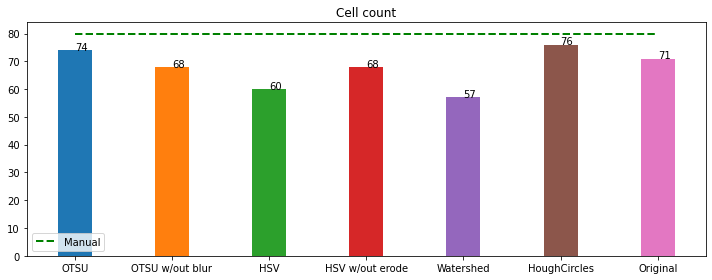

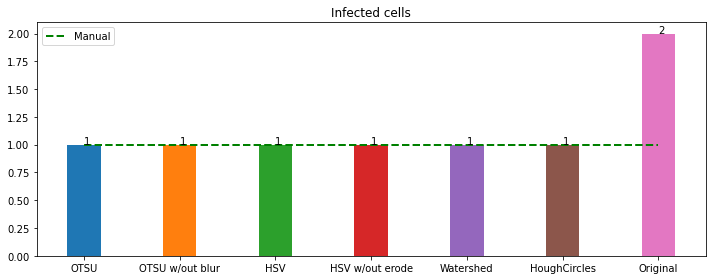

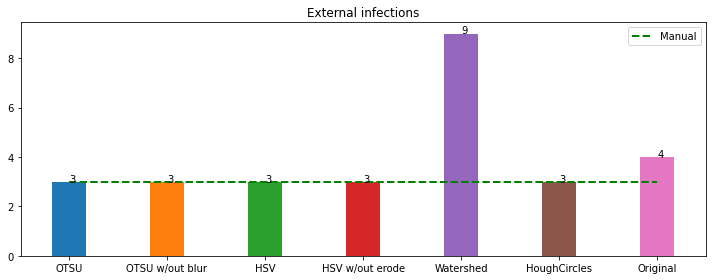

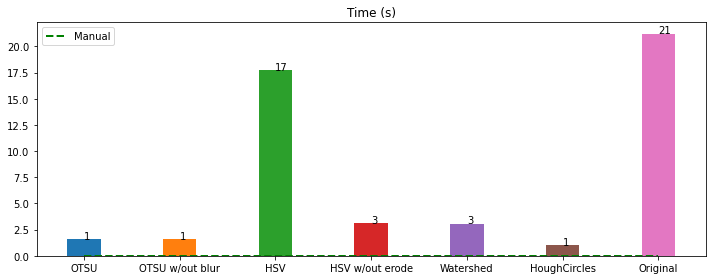

In [9]:

def graph(data,value):
    labels   = []
    
    x = np.arange(len(data)-1)  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(10,4))

    pos = 0
    for method in data:
        if method["method"] == "Manual":
            plt.plot([method[value] for x in range(len(data)-1)], 
                         linestyle='dashed', 
                         linewidth=2, 
                         color='green',
                         label='Manual')
        else:
            labels.append(method['method'])
            rects1 = ax.bar(pos, method[value], width)
            ax.text(pos,method[value], int(method[value]))
            pos += 1

    
    if value == 'cells':
        ax.set_title('Cell count')
    if value == 'internal':
        ax.set_title('Infected cells')
    if value == 'external':
        ax.set_title('External infections')
    if value == 'time':
        ax.set_title('Time (s)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()
    
    
smp = 0
data = samples[smp]['data']
print(samples[smp]["name"])
graph(data,'cells')
graph(data,'internal')
graph(data,'external')
graph(data,'time')

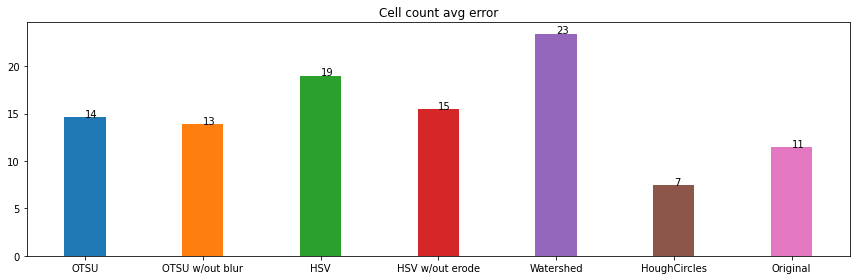

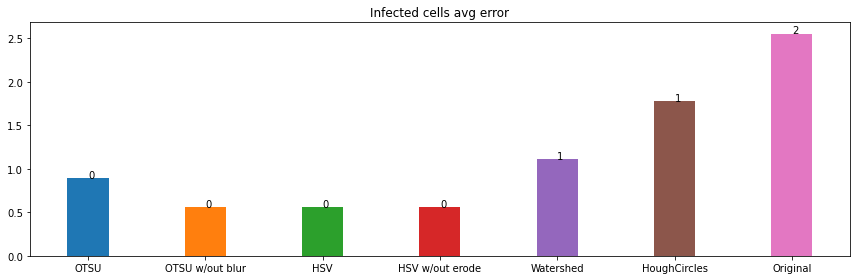

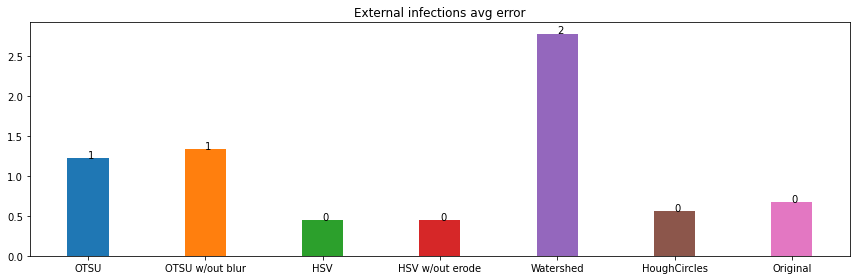

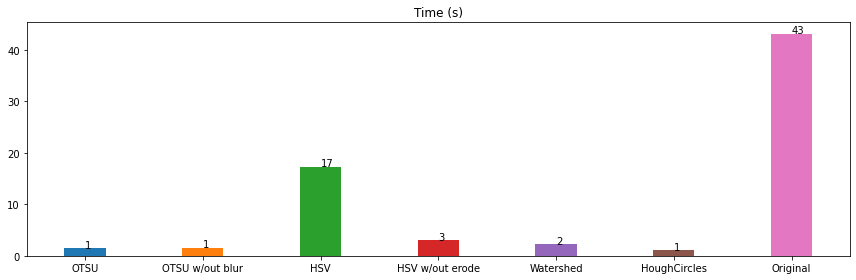

In [10]:
average = []
for smp in samples:
    data = smp['data']
    for method in data:
        if method['method'] == 'Manual':
            manual = method
            break
            
    for method in data:
        if method['method'] == 'Manual':
            continue
        
        found = False
        for avg in average:
            if avg['method'] == method['method']:
                found = True
                avg['cells']    += abs(manual['cells']-method['cells'])
                avg['internal'] += abs(manual['internal']-method['internal'])
                avg['external'] += abs(manual['external']-method['external'])
                avg['time']     += abs(manual['time']-method['time'])
        
        if found == False:
            average.append({"method"  : method['method'],
                            "cells"   : abs(manual['cells']-method['cells']),
                            "internal": abs(manual['internal']-method['internal']),
                            "external": abs(manual['external']-method['external']),
                            "time"    : abs(manual['time']-method['time'])})
            
for avg in average:
    avg['cells']    = avg['cells']/len(samples)
    avg['internal'] = avg['internal']/len(samples)
    avg['external'] = avg['external']/len(samples)
    avg['time']     = avg['time']/len(samples)

def errorGraph(data,value):
    labels   = []

    x = np.arange(len(data))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(12,4))

    pos = 0
    for method in data:
        labels.append(method['method'])
        rects1 = ax.bar(pos, method[value], width)
        ax.text(pos,method[value], int(method[value]))
        pos += 1


    if value == 'cells':
        ax.set_title('Cell count avg error')
    if value == 'internal':
        ax.set_title('Infected cells avg error')
    if value == 'external':
        ax.set_title('External infections avg error')
    if value == 'time':
        ax.set_title('Time (s)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    fig.tight_layout()

    plt.show()
    
    
errorGraph(average,'cells')
errorGraph(average,'internal')
errorGraph(average,'external')
errorGraph(average,'time')

# Qualitative

In [2]:
def getManualCount(name):
    img = cv2.imread(name,1)
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    cells, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (17,200,200), (76,255,255))
    internal, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (0,0,0), (1,1,255))
    mask = cv2.erode(mask,np.ones((15,15),np.uint8))
    external, _, cc, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    for c in cc:
        cv2.circle(img, (int(c[0]), int(c[1])), 25, (255,255,255), -1)
    
    return {"method":"Manual",
            "cells":cells-1,
            "internal":internal-1,
            "external":external-1,
            "path":name,
            "time":0}


def getOriginalCount(name):
    name1 = name.replace("samples/","samples/result/") + "_resultText.txt"
    f = open(name1,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    data = lines[1].split()
    cells = int(data[1])
    #no txt do proj original esta saindo a contagem errada
    #infectados sao os que estao externos as celulas
    external = int(data[2])
    
    name2 = name.replace("samples/","samples/result/") + "_infoTextHSV.txt"
    f = open(name2,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.strip().split("\n")
    lines.pop(0)
    internal = len(lines)-external
    
    
    return {"method"  :"Original",
            "cells"   :cells,
            "internal":internal,
            "external":external,
            "time"    :float(data[3]),
            "path"    :name+"_segmented.jpg"}

def getProjectCount(name):
    name = name.replace("samples/","samples/myresults/") + "_result.txt"
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        data = lines[i].split("\t")
        if len(data) > 1:
            ret.append({
                'method'  : data[0].strip(),
                'cells'   : int(data[1].strip()),
                'internal': int(data[2].strip()),
                'external': int(data[3].strip()),
                'time'    : float(data[4].strip().replace("s","")),
                'path'    : data[5].strip(),
            })
    return ret


def add_to_samples(samples,values):
    if "cells_error" not in values.keys():
        values['cells_error'] = -1
    if "internal_error" not in values.keys():
        values['internal_error'] = -1
    if "external_error" not in values.keys():
        values['external_error'] = -1
        
    samples['method'].append(values["method"])
    samples['cells'].append(values["cells"])
    samples['internal'].append(values["internal"])
    samples['external'].append(values["external"])
    samples['time'].append(values["time"])
    samples['path'].append(values["path"])
    samples['cells_error'].append(values["cells_error"])
    samples['internal_error'].append(values["internal_error"])
    samples['external_error'].append(values["external_error"])
    
def calc_error(manual,dt):
    dt['cells_error']    = abs(manual["cells"]    - dt["cells"])
    dt['internal_error'] = abs(manual["internal"] - dt["internal"])
    dt['external_error'] = abs(manual["external"] - dt["external"])
    return dt


samples = {"sample":[],
           "method":[],
           "cells":[],
           "internal":[],
           "external":[],
           "time":[],
           "path":[],
           "cells_error":[],
           "internal_error":[],
           "external_error":[]}
#for file in glob.glob("./samples/*_count.jpg"):
for i in range(1,10,1):
    file = "./samples/blood_smear_%d_count.jpg" % i
    name = file.replace("_count.jpg","")
    sample_name = name.replace("./samples\\","")
    
    samples['sample'].append(sample_name)
    
    manual = getManualCount(file)
    add_to_samples(samples,manual)
    
    data = getProjectCount(name)
    for dt in data:
        samples['sample'].append(sample_name)
        dt = calc_error(manual,dt)
        add_to_samples(samples,dt)
    
    
    orig = getOriginalCount(name)
    samples['sample'].append(sample_name)
    orig = calc_error(manual,orig)
    add_to_samples(samples,orig)

samples = pd.DataFrame(data=samples)
samples

,sample,method,cells,internal,external,time,path,cells_error,internal_error,external_error
0,./samples/blood_smear_1,Manual,80,1,3,0.00000,./samples/blood_smear_1_count.jpg,-1,-1,-1
1,./samples/blood_smear_1,OTSU,74,1,3,1.44000,./samples/segmented/blood_smear_1_otsu.png,6,0,0
2,./samples/blood_smear_1,OTSU w/out blur,68,1,3,1.53000,./samples/segmented/blood_smear_1_otsu_out_blu...,12,0,0
3,./samples/blood_smear_1,HSV,60,1,3,17.08000,./samples/segmented/blood_smear_1_hsv.png,20,0,0
4,./samples/blood_smear_1,HSV w/out erode,68,1,3,3.01000,./samples/segmented/blood_smear_1_hsv_out_erod...,12,0,0
...,...,...,...,...,...,...,...,...,...,...
67,./samples/blood_smear_9,HSV,60,1,3,17.39000,./samples/segmented/blood_smear_9_hsv.png,31,0,1
68,./samples/blood_smear_9,HSV w/out erode,68,1,3,3.14000,./samples/segmented/blood_smear_9_hsv_out_erod...,23,0,1
69,./samples/blood_smear_9,Watershed,52,0,16,4.38000,./samples/segmented/blood_smear_9_watershed.png,39,1,14
70,./samples/blood_smear_9,HoughCircles,76,7,2,1.52000,./samples/segmented/blood_smear_9_hough.png,15,6,0


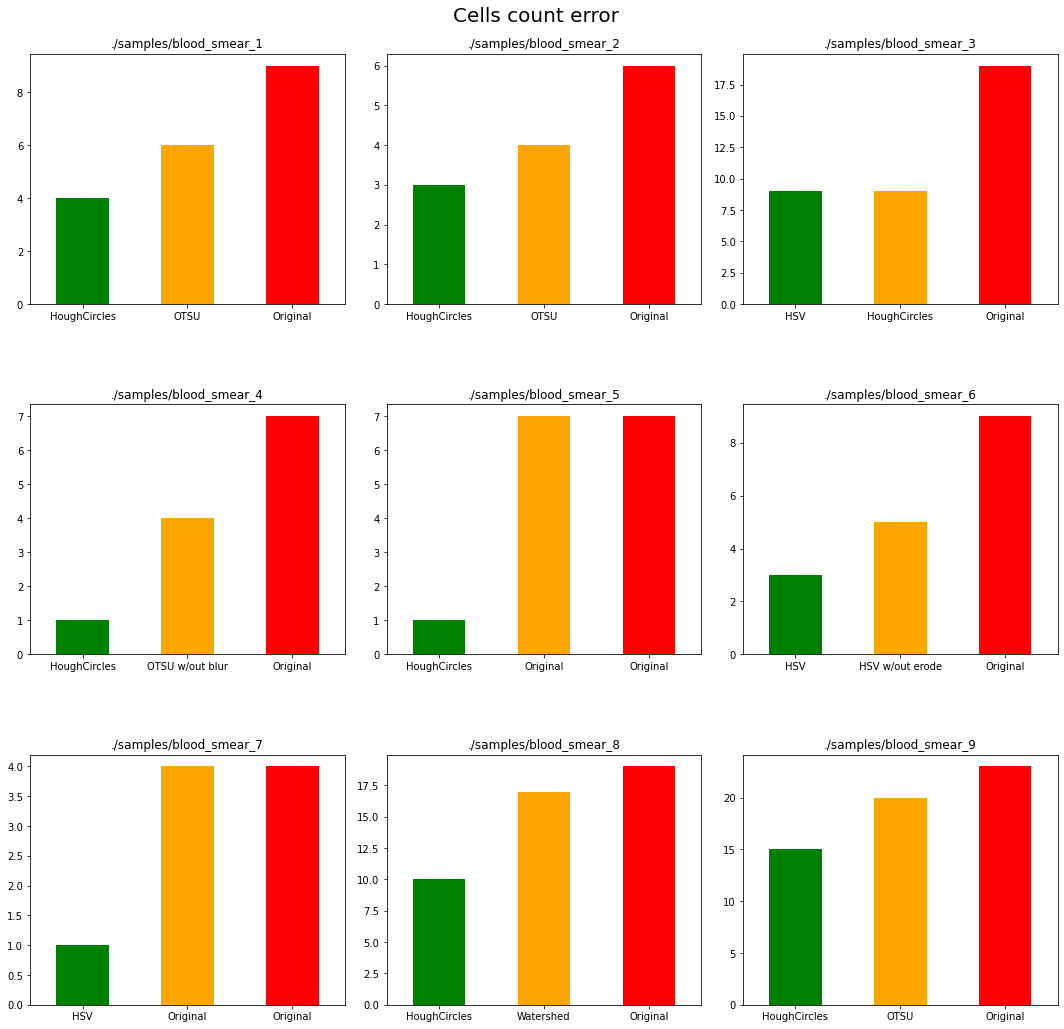

In [27]:
samples_list = samples[["sample"]].drop_duplicates().values
samples_list = samples_list.reshape(len(samples_list))

fig, axes = plt.subplots(ncols=3,nrows=3,figsize=(15,15))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Cells count error", fontsize=20)
plt.subplots_adjust(hspace = .4)

pos = [(j,i) for j in range(3) for i in range(3)]
i = 0
for smp_name in samples_list:

    smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
    smp = pd.concat([smp.nsmallest(2,'cells_error'), smp.loc[smp['method'] == "Original"]])
    ax = smp[["method","cells_error"]].plot.bar(x='method',
                                                y='cells_error',
                                                color=['green','orange','red'],
                                                ax=axes[pos[i]],
                                                title=smp_name,
                                                rot=0)
    ax.get_legend().remove()
    ax.set_xlabel('')
    
    i += 1



In [41]:
samples_list = samples[["sample"]].drop_duplicates().values
samples_list = samples_list.reshape(len(samples_list))

fig, axes = plt.subplots(nrows=9,ncols=4,figsize=(30,30))
fig.tight_layout(rect=[0, .03, 0.5, 0.95])
fig.suptitle("Cells count error", fontsize=20, x=0.1)
plt.subplots_adjust( hspace=0.4 )

pos = [(j,i) for j in range(9) for i in range(4)]
i = 0
for smp_name in samples_list:

    smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
    smp = pd.concat([smp.nsmallest(2,'cells_error'), smp.loc[smp['method'] == "Original"]])
    ax = smp[["method","cells_error"]].plot.bar(x='method',
                                                y='cells_error',
                                                color=['green','orange','red'],
                                                ax=axes[pos[i]],
                                                title=smp_name,
                                                rot=0)
    ax.get_legend().remove()
    ax.set_xlabel('')
    i += 1
    
    for v in smp.values:
        img = cv2.cvtColor(cv2.imread(v[6]),cv2.COLOR_BGR2RGB)
        axes[pos[i]].set_title(v[1])
        axes[pos[i]].imshow(img)
        axes[pos[i]].axis('off')
        i += 1

plt.savefig("tmp.png",dpi=150)
plt.close()

zoom("tmp.png")
